In [171]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)
import matplotlib as mpl
mpl.style.use('seaborn-whitegrid')
import function

from BS import BS_call, BS_delta, BS_gamma
from display import plot_2Dfunc, plot_3Dfunc
from Optimize import nelder_mead_global

# Convert pd.timestamp to int (int=days between two date)
def convert_date_to_maturity(calculation_date, expiry_date):
    return (expiry_date-calculation_date).days

In [172]:
df = pd.read_excel('Data_TD3.xlsx', header = 2, index_col = 0)
df.rename(columns={'Prix action':'stock_price', 'Prix option strike 6':'call_price_K6', 'Prix option strike 6,5':'call_price_K6.5'}, inplace=True)

# Initialize column
df['expiry']=np.nan
# Define maturity
maturity=datetime.datetime(2018,12,31)
maturity = pd.Timestamp(maturity)
# Fill expiry col with float expiry
for id_date in df.index:
    df.loc[id_date]['expiry'] = convert_date_to_maturity(id_date, maturity)

# Days to years
df['expiry']=df['expiry'].map(lambda x: x/365)
df.dropna(inplace=True)

df['IV_K6'] = np.nan
df['IV_K6.5'] = np.nan
for index in df.index[:]:
    dict_param_K6 = {
        'K':6,
        'S':df.loc[index]['stock_price'],
        'r': 0.0,
        'T' : df.loc[index]['expiry'],
        'market_price': df.loc[index]['call_price_K6']
    }
    dict_param_K6_5 = {
        'K':6.5,
        'S':df.loc[index]['stock_price'],
        'r': 0.0,
        'T' : df.loc[index]['expiry'],
        'market_price': df.loc[index]['call_price_K6.5']
    }
    df.loc[index]['IV_K6'] = nelder_mead_global(1, function.BS_european_call,0,1, **dict_param_K6)[0]
    df.loc[index]['IV_K6.5'] = nelder_mead_global(1, function.BS_european_call,0,1, **dict_param_K6_5)[0]
df.head()

,stock_price,call_price_K6,call_price_K6.5,expiry,IV_K6,IV_K6.5
Date,,,,,,
2017-10-04,6.910,1.02096,0.59093,1.241096,0.145857,0.116967
2017-10-05,7.006,1.09932,0.65885,1.238356,0.144790,0.116567
2017-10-06,7.000,1.09306,0.65440,1.235616,0.144311,0.116687
2017-10-09,6.950,1.04813,0.61591,1.227397,0.143378,0.116282
2017-10-10,6.856,0.96879,0.54811,1.224658,0.142961,0.115753


# Delta Hedging

In [173]:
K = 6
r = 0
df_deltaHedging = pd.DataFrame(index = pd.to_datetime(df.index), 
                      columns = ['expiry','stock_price','call_price_K6','IV_K6','delta_K6', 'replicated_portfolio', 'poche_action', 'poche_cash'],
                     dtype = 'float')
df_deltaHedging['expiry'] = df['expiry'].copy()
df_deltaHedging['stock_price'] = df['stock_price'].copy()
df_deltaHedging['call_price_K6'] = df['call_price_K6'].copy()
df_deltaHedging['IV_K6'] = df['IV_K6'].copy()

df_deltaHedging.head()

,expiry,stock_price,call_price_K6,IV_K6,delta_K6,replicated_portfolio,poche_action,poche_cash
Date,,,,,,,,
2017-10-04,1.241096,6.910,1.02096,0.145857,NaN,NaN,NaN,NaN
2017-10-05,1.238356,7.006,1.09932,0.144790,NaN,NaN,NaN,NaN
2017-10-06,1.235616,7.000,1.09306,0.144311,NaN,NaN,NaN,NaN
2017-10-09,1.227397,6.950,1.04813,0.143378,NaN,NaN,NaN,NaN
2017-10-10,1.224658,6.856,0.96879,0.142961,NaN,NaN,NaN,NaN


In [174]:
for i, index in enumerate(df_deltaHedging.index):
    df_deltaHedging.loc[index]['delta_K6'] = BS_delta(df_deltaHedging.loc[index]['stock_price'],K,df_deltaHedging.loc[index]['expiry'],r,df_deltaHedging.loc[index]['IV_K6'])
    if i == 0 :
        df_deltaHedging.iloc[0]['replicated_portfolio'] = df_deltaHedging.iloc[0]['call_price_K6']
    else:
        df_deltaHedging.loc[index]['poche_action'] = df_deltaHedging.loc[index]['delta_K6']*df_deltaHedging.loc[index]['stock_price']
        df_deltaHedging.iloc[i]['replicated_portfolio'] = df_deltaHedging.iloc[i-1]['replicated_portfolio'] + df_deltaHedging.iloc[i-1]['delta_K6']*(df_deltaHedging.iloc[i]['stock_price']-df_deltaHedging.iloc[i-1]['stock_price'])
        df_deltaHedging.loc[index]['poche_cash'] = df_deltaHedging.loc[index]['replicated_portfolio'] - df_deltaHedging.loc[index]['delta_K6']*df_deltaHedging.loc[index]['stock_price']
df_deltaHedging

,expiry,stock_price,call_price_K6,IV_K6,delta_K6,replicated_portfolio,poche_action,poche_cash
Date,,,,,,,,
2017-10-04,1.241096,6.910,1.02096,0.145857,0.829014,1.020960,NaN,NaN
2017-10-05,1.238356,7.006,1.09932,0.144790,0.851433,1.100545,5.965140,-4.864595
2017-10-06,1.235616,7.000,1.09306,0.144311,0.851100,1.095437,5.957703,-4.862266
2017-10-09,1.227397,6.950,1.04813,0.143378,0.842488,1.052882,5.855294,-4.802412
2017-10-10,1.224658,6.856,0.96879,0.142961,0.821757,0.973688,5.633969,-4.660281
...,...,...,...,...,...,...,...,...
2018-09-27,0.260274,6.028,0.37835,0.297815,0.542451,0.065463,3.269897,-3.204433
2018-09-28,0.257534,5.844,0.28498,0.298547,0.460916,-0.034348,2.693591,-2.727939
2018-10-01,0.249315,5.724,0.24261,0.312172,0.411308,-0.089657,2.354328,-2.443986


<AxesSubplot:xlabel='Date'>

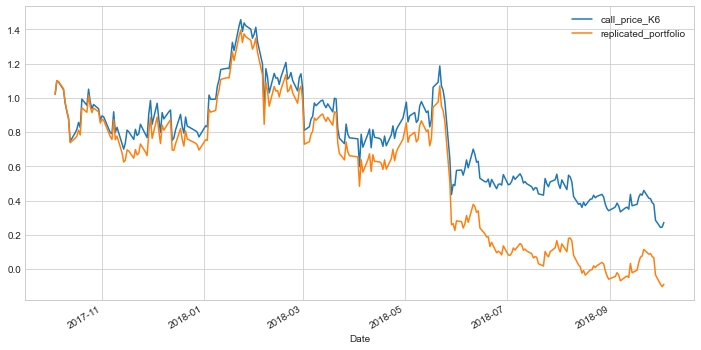

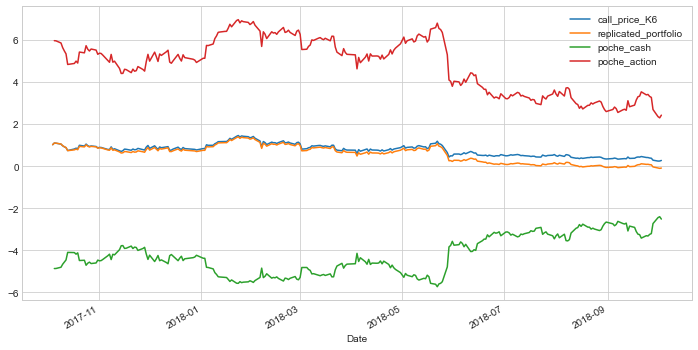

In [175]:
df_deltaHedging[['call_price_K6', 'replicated_portfolio']].plot()
df_deltaHedging[['call_price_K6','replicated_portfolio','poche_cash','poche_action']].plot()

# Delta-Gamma Hedging

In [176]:
K = 6
_K = 6.5
r = 0.0
df_DeltaGammaHedging = pd.DataFrame(index = pd.to_datetime(df.index), 
                      columns = ['expiry','stock_price','call_price_K6','call_price_K6.5','IV_K6','IV_K6.5',
                                 'delta_K6','delta_K6.5','gamma_K6', 'gamma_K6.5',
                                 'replicated_portfolio', 'quantity_stock', 'quantity_option_K6.5',
                                 'poche_action', 'poche_cash', 'poche_option_K6.5'],
                     dtype = 'float')
df_DeltaGammaHedging['expiry'] = df['expiry'].copy()
df_DeltaGammaHedging['stock_price'] = df['stock_price'].copy()
df_DeltaGammaHedging['call_price_K6'] = df['call_price_K6'].copy()
df_DeltaGammaHedging['call_price_K6.5'] = df['call_price_K6.5'].copy()
df_DeltaGammaHedging['IV_K6'] = df['IV_K6'].copy()
df_DeltaGammaHedging['IV_K6.5'] = df['IV_K6.5'].copy()
df_DeltaGammaHedging.head()

,expiry,stock_price,call_price_K6,call_price_K6.5,IV_K6,IV_K6.5,delta_K6,delta_K6.5,gamma_K6,gamma_K6.5,replicated_portfolio,quantity_stock,quantity_option_K6.5,poche_action,poche_cash,poche_option_K6.5
Date,,,,,,,,,,,,,,,,
2017-10-04,1.241096,6.910,1.02096,0.59093,0.145857,0.116967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-05,1.238356,7.006,1.09932,0.65885,0.144790,0.116567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-06,1.235616,7.000,1.09306,0.65440,0.144311,0.116687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-09,1.227397,6.950,1.04813,0.61591,0.143378,0.116282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-10,1.224658,6.856,0.96879,0.54811,0.142961,0.115753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [177]:
for i, index in enumerate(df_DeltaGammaHedging.index):
    df_DeltaGammaHedging.loc[index]['delta_K6'] = BS_delta(df_DeltaGammaHedging.loc[index]['stock_price'],K,df_DeltaGammaHedging.loc[index]['expiry'], r, df_DeltaGammaHedging.loc[index]['IV_K6'])
    df_DeltaGammaHedging.loc[index]['delta_K6.5'] = BS_delta(df_DeltaGammaHedging.loc[index]['stock_price'],_K,df_DeltaGammaHedging.loc[index]['expiry'], r, df_DeltaGammaHedging.loc[index]['IV_K6.5'])
    df_DeltaGammaHedging.loc[index]['gamma_K6'] = BS_gamma(df_DeltaGammaHedging.loc[index]['stock_price'],K,df_DeltaGammaHedging.loc[index]['expiry'], r, df_DeltaGammaHedging.loc[index]['IV_K6'])
    df_DeltaGammaHedging.loc[index]['gamma_K6.5'] = BS_gamma(df_DeltaGammaHedging.loc[index]['stock_price'],_K,df_DeltaGammaHedging.loc[index]['expiry'], r, df_DeltaGammaHedging.loc[index]['IV_K6.5'])
   
    df_DeltaGammaHedging.loc[index]['quantity_stock'] = (df_DeltaGammaHedging.loc[index]['delta_K6'] - 
                                        df_DeltaGammaHedging.loc[index]['delta_K6.5']*df_DeltaGammaHedging.loc[index]['gamma_K6']/df_DeltaGammaHedging.loc[index]['gamma_K6.5'])
    df_DeltaGammaHedging.loc[index]['poche_action'] =  df_DeltaGammaHedging.loc[index]['quantity_stock']*df_DeltaGammaHedging.loc[index]['stock_price']
    df_DeltaGammaHedging.loc[index]['quantity_option_K6.5'] = df_DeltaGammaHedging.loc[index]['gamma_K6']/df_DeltaGammaHedging.loc[index]['gamma_K6.5']
    df_DeltaGammaHedging.loc[index]['poche_option_K6.5'] = df_DeltaGammaHedging.loc[index]['quantity_option_K6.5']*df_DeltaGammaHedging.loc[index]['call_price_K6.5']
    
    if i == 0 :
        df_DeltaGammaHedging.iloc[i]['replicated_portfolio'] = df_DeltaGammaHedging.iloc[i]['call_price_K6']
    else:
        df_DeltaGammaHedging.iloc[i]['replicated_portfolio'] = df_DeltaGammaHedging.iloc[i-1]['replicated_portfolio'] + df_DeltaGammaHedging.iloc[i-1]['quantity_stock']*(df_DeltaGammaHedging.iloc[i]['stock_price']-df_DeltaGammaHedging.iloc[i-1]['stock_price'])+ df_DeltaGammaHedging.iloc[i-1]['quantity_option_K6.5']*(df_DeltaGammaHedging.iloc[i]['call_price_K6.5']-df_DeltaGammaHedging.iloc[i-1]['call_price_K6.5'])
    
    df_DeltaGammaHedging.loc[index]['poche_cash'] = df_DeltaGammaHedging.loc[index]['replicated_portfolio'] - df_DeltaGammaHedging.loc[index]['poche_action'] - df_DeltaGammaHedging.loc[index]['poche_option_K6.5']
df_DeltaGammaHedging

,expiry,stock_price,call_price_K6,call_price_K6.5,IV_K6,IV_K6.5,delta_K6,delta_K6.5,gamma_K6,gamma_K6.5,replicated_portfolio,quantity_stock,quantity_option_K6.5,poche_action,poche_cash,poche_option_K6.5
Date,,,,,,,,,,,,,,,,
2017-10-04,1.241096,6.910,1.02096,0.59093,0.145857,0.116967,0.829014,0.703524,0.226210,0.384072,1.020960,0.414654,0.588977,2.865259,-2.192344,0.348044
2017-10-05,1.238356,7.006,1.09932,0.65885,0.144790,0.116567,0.851433,0.739812,0.205228,0.357049,1.100770,0.426196,0.574791,2.985926,-2.263857,0.378701
2017-10-06,1.235616,7.000,1.09306,0.65440,0.144311,0.116687,0.851100,0.737677,0.206623,0.358886,1.095655,0.426395,0.575734,2.984762,-2.265867,0.376760
2017-10-09,1.227397,6.950,1.04813,0.61591,0.143378,0.116282,0.842488,0.720398,0.218143,0.375712,1.052175,0.424217,0.580611,2.948310,-2.253739,0.357604
2017-10-10,1.224658,6.856,0.96879,0.54811,0.142961,0.115753,0.821757,0.684497,0.240430,0.404767,0.972934,0.415169,0.593996,2.846397,-2.199039,0.325575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-27,0.260274,6.028,0.37835,0.26191,0.297815,0.361410,0.542451,0.375745,0.433118,0.341386,0.533748,0.065741,1.268707,0.396286,-0.194825,0.332287
2018-09-28,0.257534,5.844,0.28498,0.19737,0.298547,0.362254,0.460916,0.313205,0.448413,0.329848,0.439770,0.035128,1.359454,0.205287,-0.033832,0.268315
2018-10-01,0.249315,5.724,0.24261,0.16974,0.312172,0.376126,0.411308,0.279931,0.436043,0.313102,0.397993,0.021461,1.392654,0.122841,0.038762,0.236389


<AxesSubplot:xlabel='Date'>

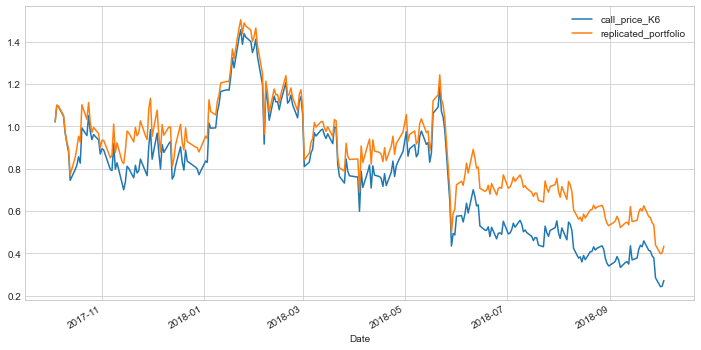

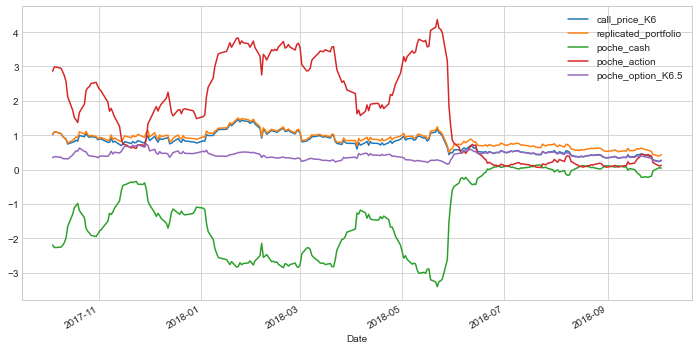

In [178]:
df_DeltaGammaHedging[['call_price_K6', 'replicated_portfolio']].plot()
df_DeltaGammaHedging[['call_price_K6','replicated_portfolio','poche_cash','poche_action','poche_option_K6.5']].plot()

# Delta-Vega Hedging

x | Option to be replicated C| Stock | Cash | Option 2 C'
---:|:---:|:---:| :---:|:---:
**Delta** | $\delta$ | 1 | 0 | $\delta '$
**Vega** | $\nu$ | 0 | 0 | $\nu ' \frac{\partial{\sigma '}}{\partial{\sigma}}$
**Quantity** | 1 | $w_a$ | $w_c$ | $w_o$


$\frac{\partial{C '}}{\partial{\sigma}} = \frac{\partial{C '}}{\partial{\sigma '}} \frac{\partial{\sigma '}}{\partial{\sigma}} = \nu ' \frac{\partial{\sigma '}}{\partial{\sigma}}$

An estimator of $\frac{\partial{\sigma '}}{\partial{\sigma}}$ is $\frac{\partial{\sigma '}}{\partial{\sigma}} = something$ 

We want to our replicated portfolio to have the same sensibilities as the option. Knowing that we can determine the quantities $w_a$ and $w_c$

$$
\begin{cases}
C_0 = w_{a,0} S_0 + w_{o,0} C_0 ' + w_{c,0}\\
\delta_t = w_{a,t} + w_{o,t} \delta_t '\\
\nu_t = w_{o,t} \nu ' \frac{\partial{\sigma_t '}}{\partial{\sigma}}
\end{cases}
$$

$$
\begin{cases}
w_{o,t} = \frac{\nu_t}{\nu_t ' \frac{\partial{\sigma_t '}}{\partial{\sigma}}}\\
w_{a,t} = \delta_t - \frac{\delta_t '\nu_t}{\nu_t ' \frac{\partial{\sigma_t '}}{\partial{\sigma}}}
\end{cases}
$$

In [179]:
K = 6
_K = 6.5
r = 0.0
df_DeltaVegaHedging = pd.DataFrame(index = pd.to_datetime(df.index), 
                      columns = ['expiry','stock_price','call_price_K6','call_price_K6.5','IV_K6','IV_K6.5',
                                 'delta_K6','delta_K6.5','vega_K6', 'vega_K6.5', 'sigma_deriv',
                                 'replicated_portfolio', 'quantity_stock', 'quantity_option_K6.5',
                                 'poche_action', 'poche_cash', 'poche_option_K6.5'],
                     dtype = 'float')
df_DeltaVegaHedging['expiry'] = df['expiry'].copy()
df_DeltaVegaHedging['stock_price'] = df['stock_price'].copy()
df_DeltaVegaHedging['call_price_K6'] = df['call_price_K6'].copy()
df_DeltaVegaHedging['call_price_K6.5'] = df['call_price_K6.5'].copy()
df_DeltaVegaHedging['IV_K6'] = df['IV_K6'].copy()
df_DeltaVegaHedging['IV_K6.5'] = df['IV_K6.5'].copy()
df_DeltaVegaHedging

,expiry,stock_price,call_price_K6,call_price_K6.5,IV_K6,IV_K6.5,delta_K6,delta_K6.5,vega_K6,vega_K6.5,sigma_deriv,replicated_portfolio,quantity_stock,quantity_option_K6.5,poche_action,poche_cash,poche_option_K6.5
Date,,,,,,,,,,,,,,,,,
2017-10-04,1.241096,6.910,1.02096,0.59093,0.145857,0.116967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-05,1.238356,7.006,1.09932,0.65885,0.144790,0.116567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-06,1.235616,7.000,1.09306,0.65440,0.144311,0.116687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-09,1.227397,6.950,1.04813,0.61591,0.143378,0.116282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-10,1.224658,6.856,0.96879,0.54811,0.142961,0.115753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-27,0.260274,6.028,0.37835,0.26191,0.297815,0.361410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-28,0.257534,5.844,0.28498,0.19737,0.298547,0.362254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-01,0.249315,5.724,0.24261,0.16974,0.312172,0.376126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [180]:
def compute_sigmaDerivEstimator(df, final_index, IV_option1='IV_K6', IV_option2='IV_K6.5', period = 15):
    sum = []
    for j, index in enumerate(df_DeltaVegaHedging.index[final_index-period+1:final_index+1]):
        sum.append((df.iloc[final_index-period+j+1][IV_option2] - df.iloc[final_index-period+j][IV_option2])/(df.iloc[final_index-period+j+1][IV_option1]-df.iloc[final_index-period+j][IV_option1]))
    return np.mean(sum)

In [ ]:
for i, index in enumerate(df_DeltaVegaHedging.index):
    df_DeltaVegaHedging.loc[index]['delta_K6'] = BS_delta(df_DeltaVegaHedging.loc[index]['stock_price'],K,df_DeltaVegaHedging.loc[index]['expiry'], r, df_DeltaVegaHedging.loc[index]['IV_K6'])
    df_DeltaVegaHedging.loc[index]['delta_K6.5'] = BS_delta(df_DeltaVegaHedging.loc[index]['stock_price'],_K,df_DeltaVegaHedging.loc[index]['expiry'], r, df_DeltaVegaHedging.loc[index]['IV_K6.5'])
    df_DeltaVegaHedging.loc[index]['vega_K6'] = BS_gamma(df_DeltaVegaHedging.loc[index]['stock_price'],K,df_DeltaVegaHedging.loc[index]['expiry'], r, df_DeltaVegaHedging.loc[index]['IV_K6'])
    df_DeltaVegaHedging.loc[index]['vega_K6.5'] = BS_gamma(df_DeltaVegaHedging.loc[index]['stock_price'],_K,df_DeltaVegaHedging.loc[index]['expiry'], r, df_DeltaVegaHedging.loc[index]['IV_K6.5'])
    
    df_DeltaVegaHedging.loc[index]['sigma_deriv'] = compute_sigmaDerivEstimator(df_DeltaVegaHedging, df_DeltaVegaHedging.index.get_loc(index), 'IV_K6', 'IV_K6.5', 15)
    
    df_DeltaVegaHedging.loc[index]['quantity_stock'] = df_DeltaVegaHedging.loc[index]['delta_K6'] - (df_DeltaVegaHedging.loc[index]['delta_K6.5']*df_DeltaVegaHedging.loc[index]['vega_K6'])/(df_DeltaVegaHedging.loc[index]['vega_K6.5']*df_DeltaVegaHedging.loc[index]['sigma_deriv'])
    df_DeltaVegaHedging.loc[index]['quantity_option_K6.5'] = df_DeltaVegaHedging.loc[index]['vega_K6']/(df_DeltaVegaHedging.loc[index]['vega_K6.5']*df_DeltaVegaHedging.loc[index]['sigma_deriv'])
    
    df_DeltaVegaHedging.loc[index]['poche_action'] =  df_DeltaVegaHedging.loc[index]['quantity_stock']*df_DeltaVegaHedging.loc[index]['stock_price']
    df_DeltaVegaHedging.loc[index]['poche_option_K6.5'] = df_DeltaVegaHedging.loc[index]['quantity_option_K6.5']*df_DeltaVegaHedging.loc[index]['call_price_K6.5']
    if pd.isna(df_DeltaVegaHedging.iloc[i-1]['sigma_deriv']):
        df_DeltaVegaHedging.iloc[i]['replicated_portfolio'] = df_DeltaVegaHedging.iloc[i]['call_price_K6']
    else:
        df_DeltaVegaHedging.iloc[i]['replicated_portfolio'] = df_DeltaVegaHedging.iloc[i-1]['replicated_portfolio'] + df_DeltaVegaHedging.iloc[i-1]['quantity_stock']*(df_DeltaVegaHedging.iloc[i]['stock_price']-df_DeltaVegaHedging.iloc[i-1]['stock_price'])+ df_DeltaVegaHedging.iloc[i-1]['quantity_option_K6.5']*(df_DeltaVegaHedging.iloc[i]['call_price_K6.5']-df_DeltaVegaHedging.iloc[i-1]['call_price_K6.5'])

    df_DeltaVegaHedging.loc[index]['poche_cash'] = df_DeltaVegaHedging.loc[index]['replicated_portfolio'] - df_DeltaVegaHedging.loc[index]['poche_action'] - df_DeltaVegaHedging.loc[index]['poche_option_K6.5']


<AxesSubplot:xlabel='Date'>

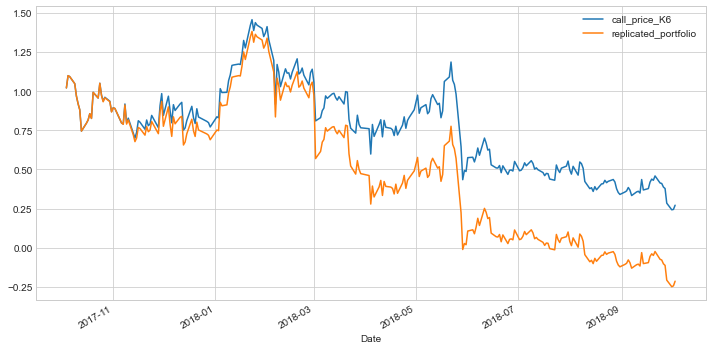

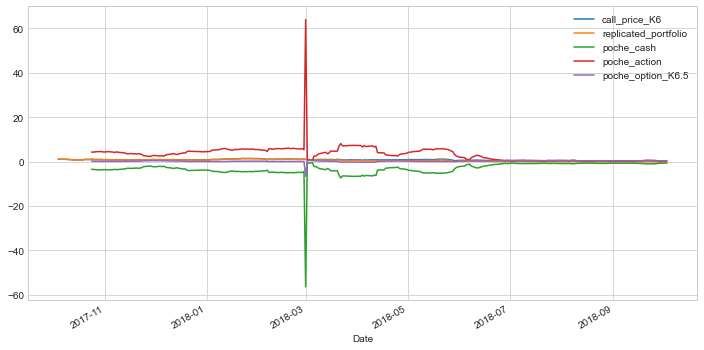

In [182]:
df_DeltaVegaHedging[['call_price_K6', 'replicated_portfolio']].plot()
df_DeltaVegaHedging[['call_price_K6','replicated_portfolio','poche_cash','poche_action','poche_option_K6.5']].plot()

<AxesSubplot:xlabel='Date'>

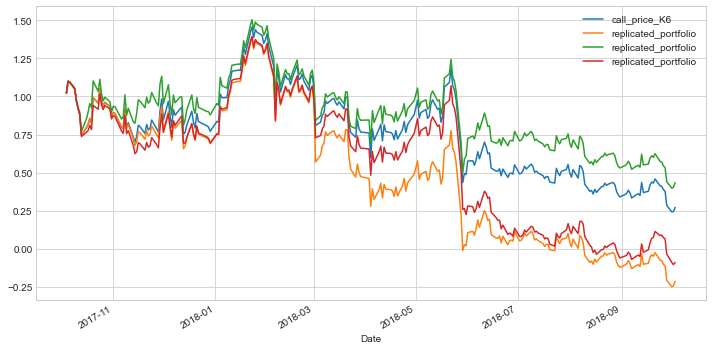

In [183]:

ax = df_DeltaVegaHedging[['call_price_K6', 'replicated_portfolio']].plot()
df_DeltaGammaHedging[['replicated_portfolio']].plot(ax=ax, label='Delta Gamma')
df_deltaHedging[['replicated_portfolio']].plot(ax=ax, label ='Delta')
